In [1]:
import pandas as pd

In [2]:
# getting the raw data:
raw_data = pd.read_csv("./sample_raw_input.csv",
                      nrows=1)
## all rows below got NaN and weird values

raw_data.head()

,L.lysine.fermentation.to.acetate.and.butanoate,pyruvate.fermentation.to.acetate.II,acetate.conversion.to.acetyl.CoA,L.lysine.biosynthesis.I,L.lysine.biosynthesis.III,L.lysine.biosynthesis.VI,acetate.formation.from.acetyl.CoA.I,acetoacetate.degradation..to.acetyl.CoA.,pyruvate.decarboxylation.to.acetyl.CoA
0,24.129287,2.13025,34.141528,26.134562,53.470057,68.188032,94.161874,9.463964,21.280398


In [3]:
# make it long format:
long_data = pd.melt(raw_data, var_name="pathways",value_name="amount")

In [4]:
long_data

,pathways,amount
0,L.lysine.fermentation.to.acetate.and.butanoate,24.129287
1,pyruvate.fermentation.to.acetate.II,2.130250
2,acetate.conversion.to.acetyl.CoA,34.141528
3,L.lysine.biosynthesis.I,26.134562
4,L.lysine.biosynthesis.III,53.470057
5,L.lysine.biosynthesis.VI,68.188032
6,acetate.formation.from.acetyl.CoA.I,94.161874
7,acetoacetate.degradation..to.acetyl.CoA.,9.463964
8,pyruvate.decarboxylation.to.acetyl.CoA,21.280398


In [5]:
# now do some RegEx to format for networkx graph:

# format for: nx.from_pandas_edgelist(df,source,target,attr)

# 1. make basic DF with specified col name:
dfInput4nx = pd.DataFrame(columns=["source","target","weight"])


In [6]:
long_data["pathways"]

0    L.lysine.fermentation.to.acetate.and.butanoate
1               pyruvate.fermentation.to.acetate.II
2                  acetate.conversion.to.acetyl.CoA
3                           L.lysine.biosynthesis.I
4                         L.lysine.biosynthesis.III
5                          L.lysine.biosynthesis.VI
6               acetate.formation.from.acetyl.CoA.I
7          acetoacetate.degradation..to.acetyl.CoA.
8            pyruvate.decarboxylation.to.acetyl.CoA
Name: pathways, dtype: object

In [7]:
import re

m = re.search("[^(and)]", "L.lysine.fermentation.to.acetate.and.butanoate")

m.group()


'L'

In [8]:
# compiling regex:

# in case of 'to':
p_to_source = re.compile("\S+?(?=\.+to)")
p_to_target = re.compile("(?<=\.to.)\S+")

# target has 'and':
p_and_firstT = re.compile("\S+(?=\.and\.)")
p_and_secondT = re.compile("(?<=\.and\.)\S+")

# sourse: just get the metabolite:
s_no_ion = re.compile("\S+(?=\.\w+ion)")

# replacing biosynthesis only's:
t_no_synth4sub = re.compile("\.\w+synthesis\S*")

# getting rid of roman numerals:
p_no_IV = re.compile("\.[IV]*$")

# getting before & after 'from':
t_from = re.compile("\S+(?=\.\S*from\.\S*)")
s_from = re.compile("(?<=from\.)\S+")

In [9]:
## testing 
wordT = "acetate.and.butanoate"
re.search(p_and_firstT,wordT)

wordS = "L.lysine.fermentation.to"
re.search(s_no_ion,wordS)

synth = "L.lysine.biosynthesis.III"
re.search(t_no_synth4sub,synth)

re.search(s_no_ion,"acetate.formation")

re.search(t_from,"acetate.formation.from.acetyl.CoA")

<re.Match object; span=(0, 17), match='acetate.formation'>

In [10]:
# 1. make basic DF with specified col name:
dfInput4nx = pd.DataFrame(columns=["source","target","weight"])

# 2. RegEx the pathway names to get source and target and fill in weight accordingly

## brute forcing lol:
for rowNum in range(len(long_data)):
    path=long_data["pathways"][rowNum]
    print(rowNum,path)
    weight = long_data["amount"][rowNum]
    
    # if path has roman numerals or period attached:
    if re.search(p_no_IV,path):
        path=re.sub(p_no_IV,"",path)
    
    # if 'to' format:
    if re.search("\.to\.", path):
        source = re.search(p_to_source,path).group()
        # if source has -ion attached:
        if re.search(s_no_ion,source):
            source = re.search(s_no_ion,source).group()
            
        target = re.search(p_to_target,path).group()
        
        # if resulting target more than 1:
        if re.search("and",target):
            #print(target)
            #print(re.search(p_and_firstT,target))
            target1=re.search(p_and_firstT,target).group()
            target2=re.search(p_and_secondT,target).group()
            
            dfInput4nx= dfInput4nx.append({"source":source, "target":target1, "weight":weight},ignore_index=True)
            dfInput4nx= dfInput4nx.append({"source":source, "target":target2, "weight":weight},ignore_index=True)
            
        # if target is just 1:
        else:
            # adding all the info to the df:
            dfInput4nx= dfInput4nx.append({"source":source, "target":target, "weight":weight},ignore_index=True)
            
    # if it has 'synthesis' but no 'to':
    if re.search(t_no_synth4sub,path):
        source = "unknown"+str(rowNum)
        target = re.sub(t_no_synth4sub,"",path)
        dfInput4nx=dfInput4nx.append({"source":source, "target":target, "weight":weight},ignore_index=True)
        
    # if it's 'from' format:
    if re.search("from",path):
        source = re.search(s_from,path).group()
        
        target = re.search(t_from,path).group()
        # if target has -ion attached:
        if re.search(s_no_ion,target):
            target = re.search(s_no_ion,target).group()
            
        dfInput4nx =dfInput4nx.append({"source":source, "target":target, "weight":weight}, ignore_index=True)
        
        print(path,source,target,weight)

    
dfInput4nx    

0 L.lysine.fermentation.to.acetate.and.butanoate
1 pyruvate.fermentation.to.acetate.II
2 acetate.conversion.to.acetyl.CoA
3 L.lysine.biosynthesis.I
4 L.lysine.biosynthesis.III
5 L.lysine.biosynthesis.VI
6 acetate.formation.from.acetyl.CoA.I
acetate.formation.from.acetyl.CoA acetyl.CoA acetate 94.1618744
7 acetoacetate.degradation..to.acetyl.CoA.
8 pyruvate.decarboxylation.to.acetyl.CoA


,source,target,weight
0,L.lysine,acetate,24.129287
1,L.lysine,butanoate,24.129287
2,pyruvate,acetate,2.130250
3,acetate,acetyl.CoA,34.141528
4,unknown3,L.lysine,26.134562
5,unknown4,L.lysine,53.470057
6,unknown5,L.lysine,68.188032
7,acetyl.CoA,acetate,94.161874
8,acetoacetate,acetyl.CoA,9.463964
9,pyruvate,acetyl.CoA,21.280398


In [11]:
import network_analysis as nt

In [12]:
from imp import reload
reload(nt)

<module 'network_analysis' from '/Users/hinakoterauchi/Google_Drive/CMSE802/Gut-Serum-Metabolome-Modeling/scripts/network_analysis.py'>

In [13]:
graph = nt.initialize_graph(dfInput4nx)

In [14]:
nt.draw_network_graph(graph)

/Users/hinakoterauchi/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/hinakoterauchi/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/hinakoterauchi/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/hinakoterauchi/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed

<Figure size 640x480 with 1 Axes>

In [15]:
import matplotlib.pyplot as plt
plt.savefig('blue_MultiDiSpring_sample1.png')

<Figure size 432x288 with 0 Axes>

In [16]:
def draw_network_graph(graph):
    """
    Plots the network graph taken from the input
    """
    import networkx as nx
    import matplotlib.pyplot as plt
    import random
    
    for u,v,d in graph.edges(data=True):
        d['weight'] = random.random()

    edges,weights = zip(*nx.get_edge_attributes(graph,'weight').items())

    
    nx.draw_networkx(graph, 
                     with_labels=True,
                     arrows=True, 
                     arrowsize=20,
                     node_size=900,
                     node_color='skyblue',
                     width=6,
                    pos=nx.spring_layout(graph,k=4),
                    edge_cmap=plt.cm.GnBu,
                    edge_color=weights,
                    edgelist=edges,
                    font_size=14)
    
    #plt.figure(figsize=(60,40))
    ax = plt.gca()
    plt.axis("off")
    ax.margins(0.08)
    
    plt.tight_layout()
    plt.show()


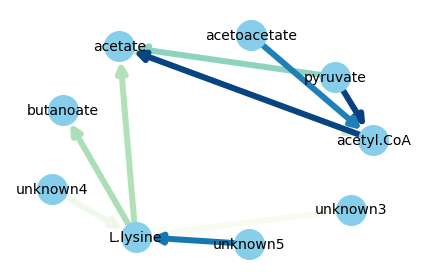

<Figure size 432x288 with 0 Axes>

In [17]:
draw_network_graph(graph)
plt.savefig('blue_MultiDiSpring_sample1.png')

In [18]:
graph.nodes
graph.edges(data=True)


OutMultiEdgeDataView([('L.lysine', 'acetate', {'weight': 0.4181451850639071}), ('L.lysine', 'butanoate', {'weight': 0.43227630469025635}), ('acetate', 'acetyl.CoA', {'weight': 0.3162420370236998}), ('pyruvate', 'acetate', {'weight': 0.5072149241127035}), ('pyruvate', 'acetyl.CoA', {'weight': 0.9877007487827949}), ('acetyl.CoA', 'acetate', {'weight': 0.9788349220010882}), ('unknown3', 'L.lysine', {'weight': 0.1203563649184145}), ('unknown4', 'L.lysine', {'weight': 0.1560439478421365}), ('unknown5', 'L.lysine', {'weight': 0.8327284118339113}), ('acetoacetate', 'acetyl.CoA', {'weight': 0.8066192226571842})])

In [19]:
graph.is_directed()

True

In [20]:
graph.is_multigraph()

True

In [21]:
import matplotlib.pyplot as plt

In [22]:
plt.figs

AttributeError: module 'matplotlib.pyplot' has no attribute 'figs'